<a href="https://colab.research.google.com/github/tadavarthi-rishi/Hand-Written-Text-extraction-from-Image/blob/master/handwritten-text-extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import division
import numpy as np
import os
import glob

from random import *
from PIL import Image
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam, RMSprop

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [24]:
d = {}
from subprocess import check_output
with open('gdrive/My Drive/forms_for_parsing.txt') as f:
    for line in f:
        key = line.split(' ')[0]
        writer = line.split(' ')[1]
        print(key, " :: ", writer)
        d[key] = writer
print(len(d.keys()))

a01-000u  ::  000
a01-000x  ::  001
a01-003  ::  002
a01-003u  ::  000
a01-003x  ::  003
a01-007  ::  004
a01-007u  ::  000
a01-007x  ::  003
a01-011  ::  005
a01-011u  ::  000
a01-011x  ::  006
a01-014  ::  007
a01-014u  ::  000
a01-014x  ::  008
a01-020  ::  009
a01-020u  ::  000
a01-020x  ::  010
a01-026  ::  009
a01-026u  ::  000
a01-026x  ::  008
a01-030  ::  005
a01-030u  ::  000
a01-030x  ::  010
a01-038  ::  007
a01-038x  ::  011
a01-043  ::  012
a01-043u  ::  000
a01-043x  ::  011
a01-049  ::  012
a01-049u  ::  000
a01-049x  ::  000
a01-053  ::  013
a01-053u  ::  000
a01-053x  ::  014
a01-058  ::  013
a01-058u  ::  000
a01-058x  ::  014
a01-063  ::  013
a01-063u  ::  000
a01-063x  ::  015
a01-068u  ::  000
a01-072u  ::  000
a01-072x  ::  001
a01-077  ::  016
a01-077u  ::  000
a01-082u  ::  000
a01-087  ::  017
a01-087u  ::  000
a01-091  ::  016
a01-091u  ::  000
a01-096u  ::  000
a01-102  ::  016
a01-102u  ::  000
a01-107  ::  018
a01-107u  ::  000
a01-113  ::  018
a01-113u  :

In [4]:
tmp = []
target_list = []

path_to_files = os.path.join('gdrive/My Drive/data', '*')
for filename in sorted(glob.glob(path_to_files)):
#     print(filename)
    tmp.append(filename)
    image_name = filename.split('/')[-1]
    file, ext = os.path.splitext(image_name)
    parts = file.split('-')
    form = parts[0] + '-' + parts[1]
    for key in d:
        if key == form:
            target_list.append(str(d[form]))

img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)
print(img_files.shape)
print(img_targets.shape)

(1340,)
(1340,)


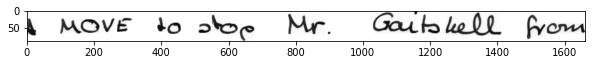

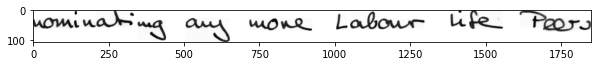

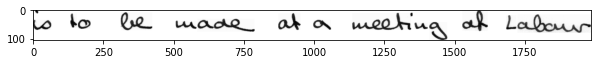

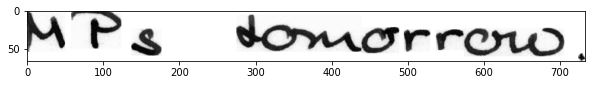

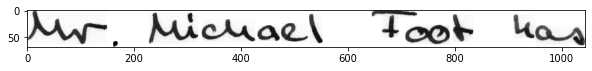

In [25]:
for filename in img_files[:5]:
    img=mpimg.imread(filename)
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap ='gray')

In [6]:
encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_Y = encoder.transform(img_targets)

print(img_files[:5], img_targets[:5], encoded_Y[:5])

['gdrive/My Drive/data/a01-000u-s00-00.png'
 'gdrive/My Drive/data/a01-000u-s00-01.png'
 'gdrive/My Drive/data/a01-000u-s00-02.png'
 'gdrive/My Drive/data/a01-000u-s00-03.png'
 'gdrive/My Drive/data/a01-000u-s01-00.png'] ['000' '000' '000' '000' '000'] [0 0 0 0 0]


In [7]:
train_files, rem_files, train_targets, rem_targets = train_test_split(
        img_files, encoded_Y, train_size=0.66, random_state=52, shuffle= True)

validation_files, test_files, validation_targets, test_targets = train_test_split(
        rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)

print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)

(884,) (228,) (228,)
(884,) (228,) (228,)


In [12]:
batch_size = 8
num_classes = 50

def generate_data(samples, target_files,  batch_size=batch_size, factor = 0.1 ):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]

            images = []
            targets = []
            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                im = Image.open(batch_sample)
                cur_width = im.size[0]
                cur_height = im.size[1]

                # print(cur_width, cur_height)
                height_fac = 113 / cur_height

                new_width = int(cur_width * height_fac)
                size = new_width, 113

                imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
                now_width = imresize.size[0]
                now_height = imresize.size[1]
                # Generate crops of size 113x113 from this resized image and keep random 10% of crops

                avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

                # Pick random x%
                pick_num = int(len(avail_x_points)*factor)

                # Now pick
                random_startx = sample(avail_x_points,  pick_num)

                for start in random_startx:
                    imcrop = imresize.crop((start, 0, start+113, 113))
                    images.append(np.asarray(imcrop))
                    targets.append(batch_target)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(targets)

            #reshape X_train for feeding in later
            X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
            #convert to float and normalize
            X_train = X_train.astype('float32')
            X_train /= 255

            #One hot encode y
            y_train = to_categorical(y_train, num_classes)
            yield shuffle(X_train, y_train)

In [13]:
train_generator = generate_data(train_files, train_targets, batch_size=batch_size, factor = 0.3)
validation_generator = generate_data(validation_files, validation_targets, batch_size=batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size=batch_size, factor = 0.1)

In [14]:
def resize_image(image):
    import tensorflow as tf
    return tf.image.resize(image,[56,56])

# Function to resize image to 64x64
row, col, ch = 113, 113, 1

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))

# Resise data within the neural network
model.add(Lambda(resize_image))  #resize images to allow for easy computation

# CNN model - Building the model suggested in paper

model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))

model.add(Convolution2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))

model.add(Convolution2D(filters= 128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, name='dense1'))  #1024
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256, name='dense2'))  #1024
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))  #softmax since output is within 50 classes

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_2 (ZeroPaddin (None, 115, 115, 1)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 56, 56, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
activation_7 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 14, 14, 64)       

In [15]:
nb_epoch = 6

samples_per_epoch = 145
nb_val_samples = 62


# #save every model using Keras checkpoint
from keras.callbacks import ModelCheckpoint
filepath="gdrive/My Drive/check-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]

# #Model fit generator
history_object = model.fit_generator(train_generator, samples_per_epoch= samples_per_epoch,
                                      validation_data=validation_generator,
                                      nb_val_samples=nb_val_samples, nb_epoch=nb_epoch, verbose=1, callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=145, epochs=6, validation_steps=62)`
  app.launch_new_instance()


Epoch 1/6
145/145 [==============================] - 975s 7s/step - loss: 2.0446 - accuracy: 0.6096 - val_loss: 1.3659 - val_accuracy: 0.6797

Epoch 00001: saving model to gdrive/My Drive/check-01-1.3659.hdf5
Epoch 2/6
145/145 [==============================] - 975s 7s/step - loss: 1.5225 - accuracy: 0.6060 - val_loss: 0.8720 - val_accuracy: 0.7018

Epoch 00002: saving model to gdrive/My Drive/check-02-0.8720.hdf5
Epoch 3/6
145/145 [==============================] - 963s 7s/step - loss: 1.2166 - accuracy: 0.6474 - val_loss: 1.2861 - val_accuracy: 0.7474

Epoch 00003: saving model to gdrive/My Drive/check-03-1.2861.hdf5
Epoch 4/6
145/145 [==============================] - 958s 7s/step - loss: 1.0885 - accuracy: 0.6610 - val_loss: 0.2814 - val_accuracy: 0.7645

Epoch 00004: saving model to gdrive/My Drive/check-04-0.2814.hdf5
Epoch 5/6
145/145 [==============================] - 967s 7s/step - loss: 0.9558 - accuracy: 0.6931 - val_loss: 0.8599 - val_accuracy: 0.7701

Epoch 00005: saving m

In [16]:
model.load_weights('gdrive/My Drive/check-06-0.4406.hdf5')
scores = model.evaluate_generator(test_generator,228) # 228 is the number of test images.
print("Accuracy = ", scores[1] , " ::" , len(scores))

Accuracy =  0.772465705871582  :: 2


In [17]:
"""Load in test data."""

images = []
for filename in test_files[:50]:
  im = Image.open(filename)

  cur_width = im.size[0]
  cur_height = im.size[1]

  print("Before Crop:", cur_width, cur_height)
  height_fac = 113 / cur_height

  new_width = int(cur_width * height_fac)
  size = new_width, 113

  imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
  now_width = imresize.size[0]
  now_height = imresize.size[1]
  print("After Crop:", now_width, now_height)
#     # Generate crops of size 113x113 from this resized image and keep random 10% of crops

  avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

#     # Pick random x%
  factor = 0.1
  pick_num = int(len(avail_x_points)*factor)
  print("Pick Number is ::", pick_num)
    
  random_startx = sample(avail_x_points,  pick_num)

  for start in random_startx:
    imcrop = imresize.crop((start, 0, start+113, 113))
    images.append(np.asarray(imcrop))
         
  X_test = np.array(images)
    
  X_test = X_test.reshape(X_test.shape[0], 113, 113, 1)
#     #convert to float and normalize
  X_test = X_test.astype('float32')
  X_test /= 255
  shuffle(X_test)

print(X_test.shape)

Before Crop: 1387 134
After Crop: 1169 113
Pick Number is :: 105
Before Crop: 481 86
After Crop: 632 113
Pick Number is :: 51
Before Crop: 1763 110
After Crop: 1811 113
Pick Number is :: 169
Before Crop: 1527 82
After Crop: 2104 113
Pick Number is :: 199
Before Crop: 1800 194
After Crop: 1048 113
Pick Number is :: 93
Before Crop: 1810 72
After Crop: 2840 113
Pick Number is :: 272
Before Crop: 1775 145
After Crop: 1383 113
Pick Number is :: 127
Before Crop: 1053 82
After Crop: 1451 113
Pick Number is :: 133
Before Crop: 1969 70
After Crop: 3178 113
Pick Number is :: 306
Before Crop: 81 59
After Crop: 155 113
Pick Number is :: 4
Before Crop: 1806 83
After Crop: 2458 113
Pick Number is :: 234
Before Crop: 1769 115
After Crop: 1738 113
Pick Number is :: 162
Before Crop: 1844 123
After Crop: 1694 113
Pick Number is :: 158
Before Crop: 1586 94
After Crop: 1906 113
Pick Number is :: 179
Before Crop: 847 65
After Crop: 1472 113
Pick Number is :: 135
Before Crop: 1890 78
After Crop: 2738 113
Pi

In [18]:
# Creating the predictive model

predictions = model.predict(X_test, verbose =1)

print(predictions.shape)
predicted_writer = []
for pred in predictions:
  predicted_writer.append(np.argmax(pred))
print(len(predicted_writer))

8666/8666 [==============================] - 5s 592us/step
(8666, 50)
8666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


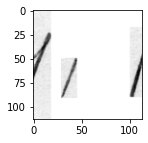

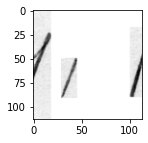

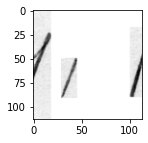

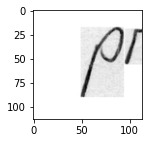

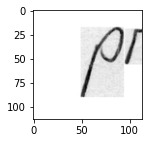

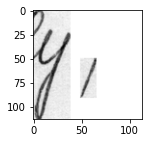

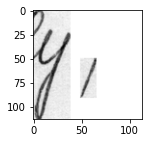

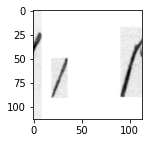

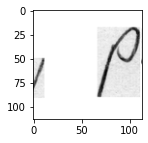

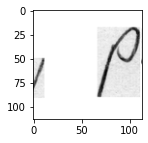

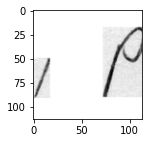

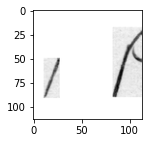

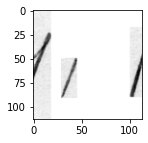

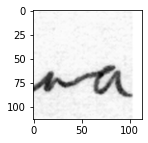

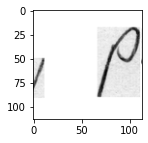

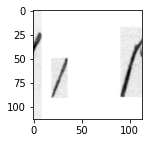

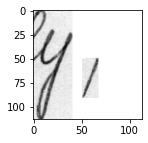

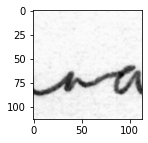

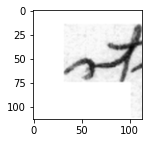

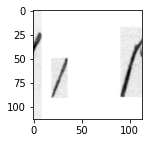

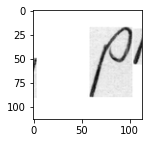

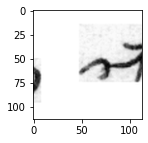

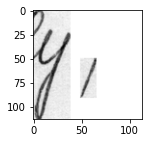

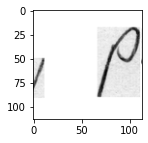

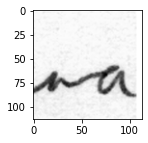

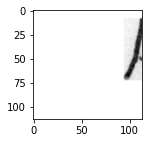

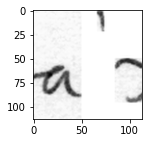

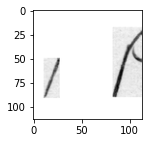

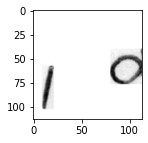

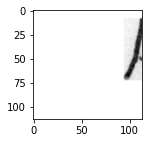

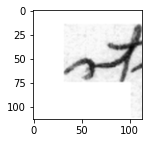

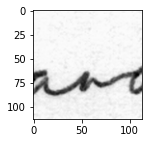

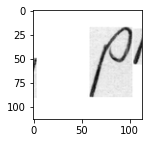

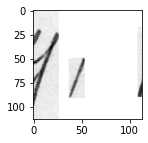

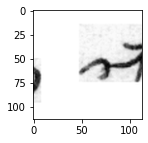

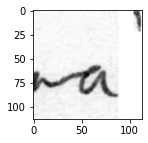

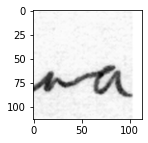

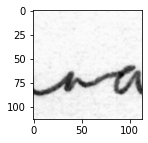

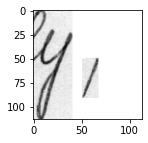

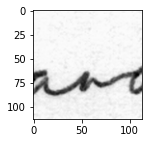

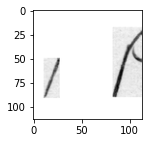

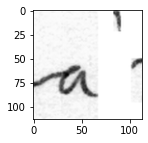

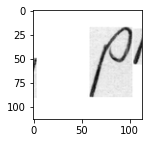

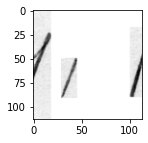

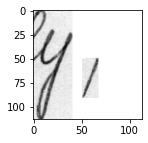

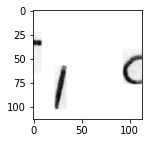

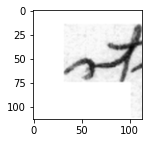

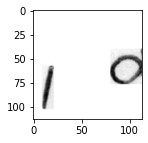

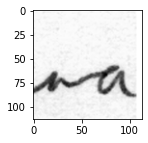

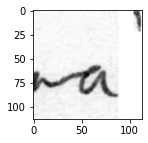

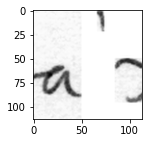

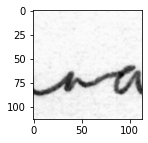

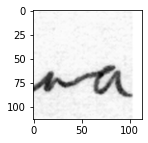

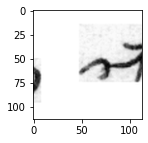

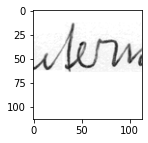

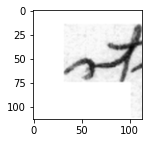

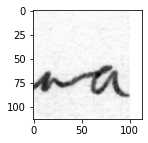

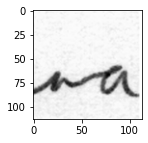

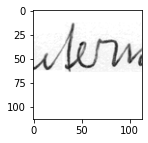

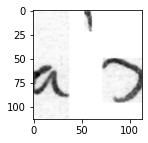

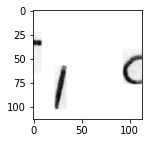

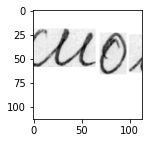

In [30]:
writer_number = 1
total_images =10
counter = 0
for i in range(len(predicted_writer)//10):
  if predicted_writer[i] == writer_number:
    image = X_test[i].squeeze()
    plt.figure(figsize=(2,2))
    plt.imshow(image, cmap ='gray')
image1=X_test[0].squeeze()
image2=X_test[1].squeeze()

plt.figure(figsize=(2,2))
plt.imshow(image2,cmap='gray')